In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/sample_data/P1.self.csv'
df = pd.read_csv(file_path)

In [ ]:
# Step 1: Create column 'a-v' populated with the name of the column ('valence' or 'arousal') that has the maximum value
df['a-v'] = df[['valence', 'arousal']].idxmax(axis=1)

In [ ]:
# Step 2: Create column 'emotion' with the appropriate emotion based on max value among specified columns
emotion_columns = ['happy', 'angry', 'nervous', 'sad', 'cheerful']
df['emotion'] = df[emotion_columns].idxmax(axis=1)

In [ ]:
# Handle the case where all values are the same (all 1s in this context)
df['emotion'] = df.apply(lambda row: 'neutral' if len(set(row[emotion_columns])) == 1 else row['emotion'], axis=1)

In [ ]:
# Step 3: Create column 'emotion1' based on the presence of 1 in specific columns
emotion1_columns = ['boredom', 'confusion', 'delight', 'concentration', 'frustration', 'surprise', 'none_1']
df['emotion1'] = df[emotion1_columns].idxmax(axis=1)

In [ ]:
df.drop(columns=['arousal','valence','cheerful','happy','angry','nervous','sad','boredom','confusion','concentration','none_1','delight','frustration','surprise'], inplace=True)

In [ ]:
# Replace 'none_1' with 'no emotion'
df['emotion1'] = df['emotion1'].replace('none_1', 'no emotion')

In [ ]:
df.head()

,seconds,arousal,valence,cheerful,happy,angry,nervous,sad,boredom,confusion,delight,concentration,frustration,surprise,none_1,a-v,emotion,emotion1
0,5,1,2,1,1,1,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,valence,neutral,boredom
1,10,1,2,1,1,1,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,valence,neutral,boredom
2,15,2,2,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,valence,neutral,no emotion
3,20,2,3,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,valence,neutral,no emotion
4,25,2,3,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,valence,neutral,no emotion


In [ ]:
df.to_csv('Processed_P1_self.csv', index=False)

In [ ]:
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, savgol_filter


In [ ]:
# Load the data
bvp_file_path = '/content/sample_data/E4_BVP.csv'
self_annotation_file_path = '/content/sample_data/Processed_P1_self.csv'

In [ ]:
bvp_data = pd.read_csv(bvp_file_path)
self_annotation_data = pd.read_csv(self_annotation_file_path)

In [ ]:
# Define the bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Define the artifact removal function
def artifact_removal(data, threshold=3.0):
    mean = np.mean(data)
    std_dev = np.std(data)
    artifact_free_data = np.where(np.abs(data - mean) > threshold * std_dev, mean, data)
    return artifact_free_data

In [ ]:
# Preprocess BVP data
fs = 64  # Sampling frequency
lowcut = 0.5  # Lower bound of the bandpass filter
highcut = 8.0  # Upper bound of the bandpass filter

In [ ]:
# Apply bandpass filter
bvp_data['filtered_value'] = bandpass_filter(bvp_data['value'], lowcut, highcut, fs)

# Normalize the signal (Z-score normalization)
bvp_data['normalized_value'] = (bvp_data['filtered_value'] - np.mean(bvp_data['filtered_value'])) / np.std(bvp_data['filtered_value'])

# Apply artifact removal
bvp_data['artifact_removed_value'] = artifact_removal(bvp_data['normalized_value'])

# Apply smoothing using Savitzky-Golay filter
bvp_data['smoothed_value'] = savgol_filter(bvp_data['artifact_removed_value'], window_length=11, polyorder=3)

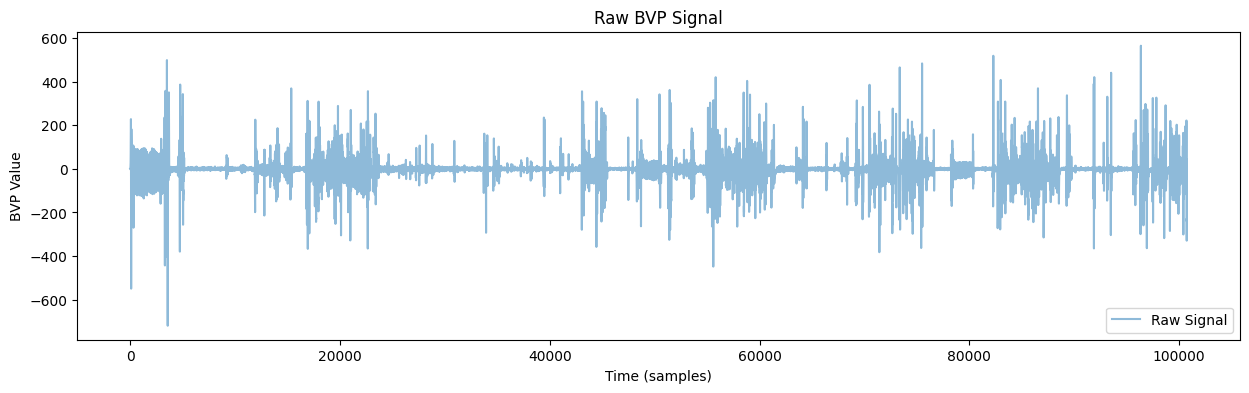

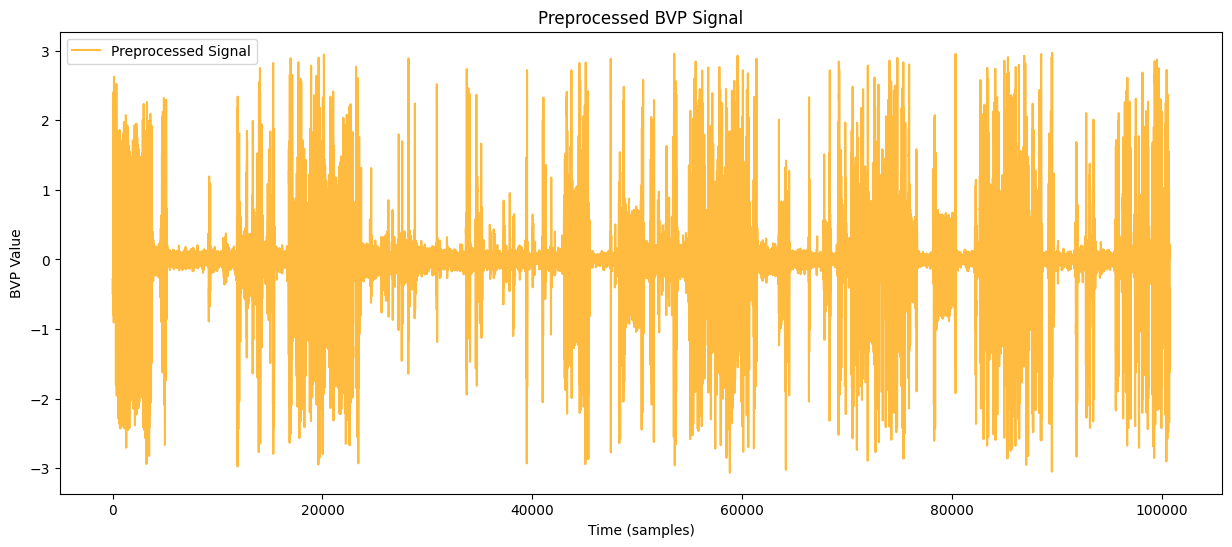

In [ ]:
# Plot the raw signal
plt.figure(figsize=(15, 4))
plt.plot(bvp_data['value'], label='Raw Signal', alpha=0.5)
plt.title('Raw BVP Signal')
plt.xlabel('Time (samples)')
plt.ylabel('BVP Value')
plt.legend()
plt.show()

# Plot the preprocessed signal
plt.figure(figsize=(15, 6))
plt.plot(bvp_data['smoothed_value'], label='Preprocessed Signal', alpha=0.75, color='orange')
plt.title('Preprocessed BVP Signal')
plt.xlabel('Time (samples)')
plt.ylabel('BVP Value')
plt.legend()
plt.show()

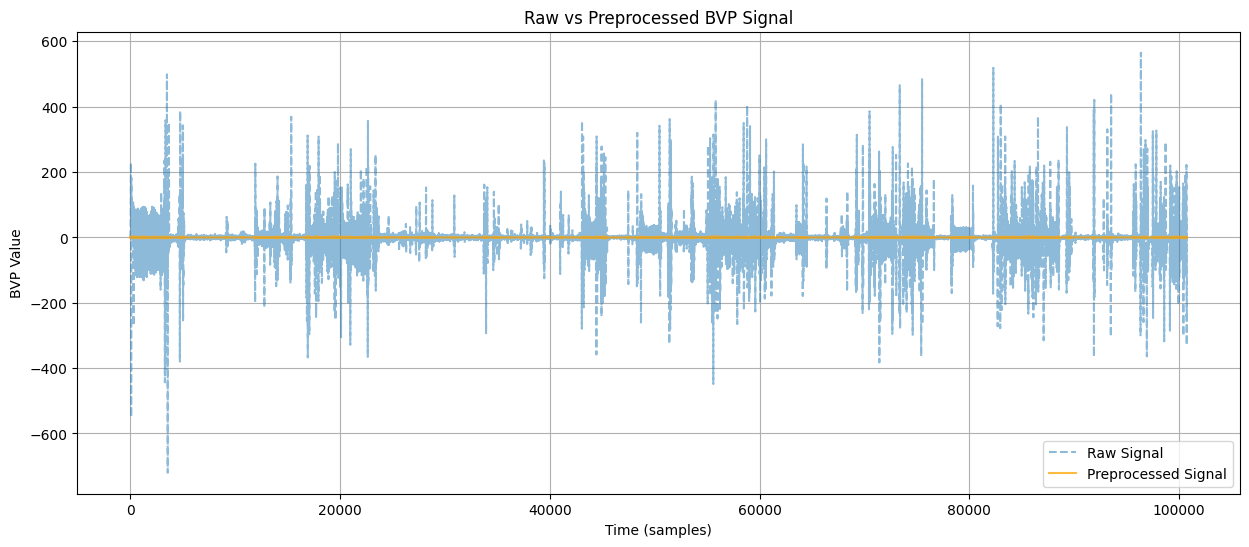

In [ ]:
# 2. Plotting raw and preprocessed signals on the same plot with different line styles
plt.figure(figsize=(15, 6))
plt.plot(bvp_data['value'], label='Raw Signal', linestyle='--', alpha=0.5)
plt.plot(bvp_data['smoothed_value'], label='Preprocessed Signal', linestyle='-', alpha=0.75, color='orange')
plt.title('Raw vs Preprocessed BVP Signal')
plt.xlabel('Time (samples)')
plt.ylabel('BVP Value')
plt.legend()
plt.grid(True)
plt.show()

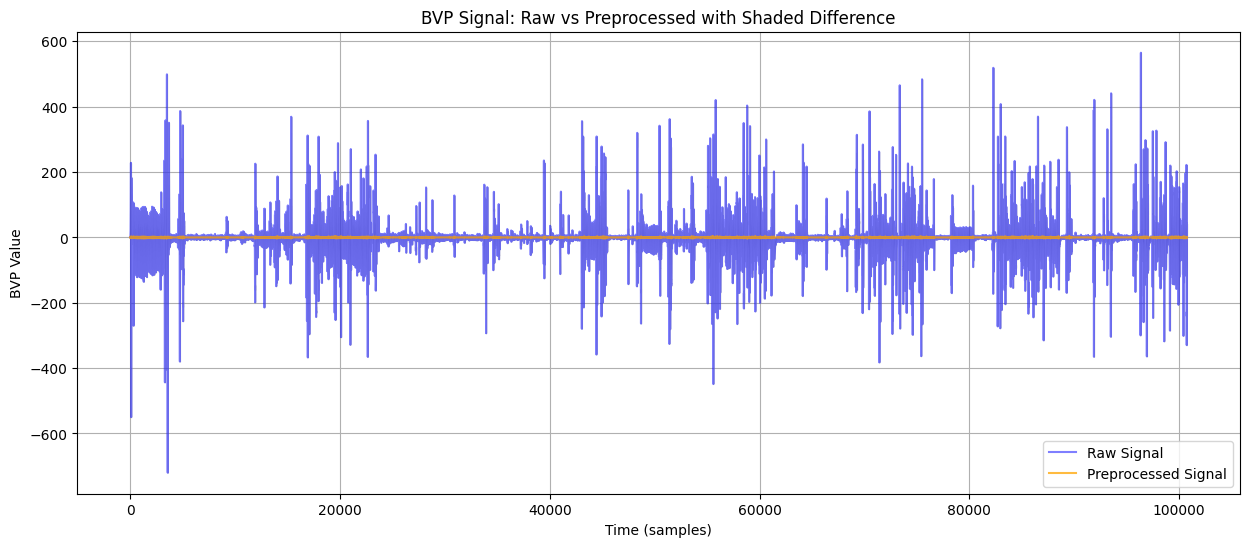

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(bvp_data['value'], label='Raw Signal', color='blue', alpha=0.5)
plt.plot(bvp_data['smoothed_value'], label='Preprocessed Signal', color='orange', alpha=0.75)
plt.fill_between(range(len(bvp_data)), bvp_data['value'], bvp_data['smoothed_value'], color='gray', alpha=0.3)
plt.title('BVP Signal: Raw vs Preprocessed with Shaded Difference')
plt.xlabel('Time (samples)')
plt.ylabel('BVP Value')
plt.legend()
plt.grid(True)
plt.show()

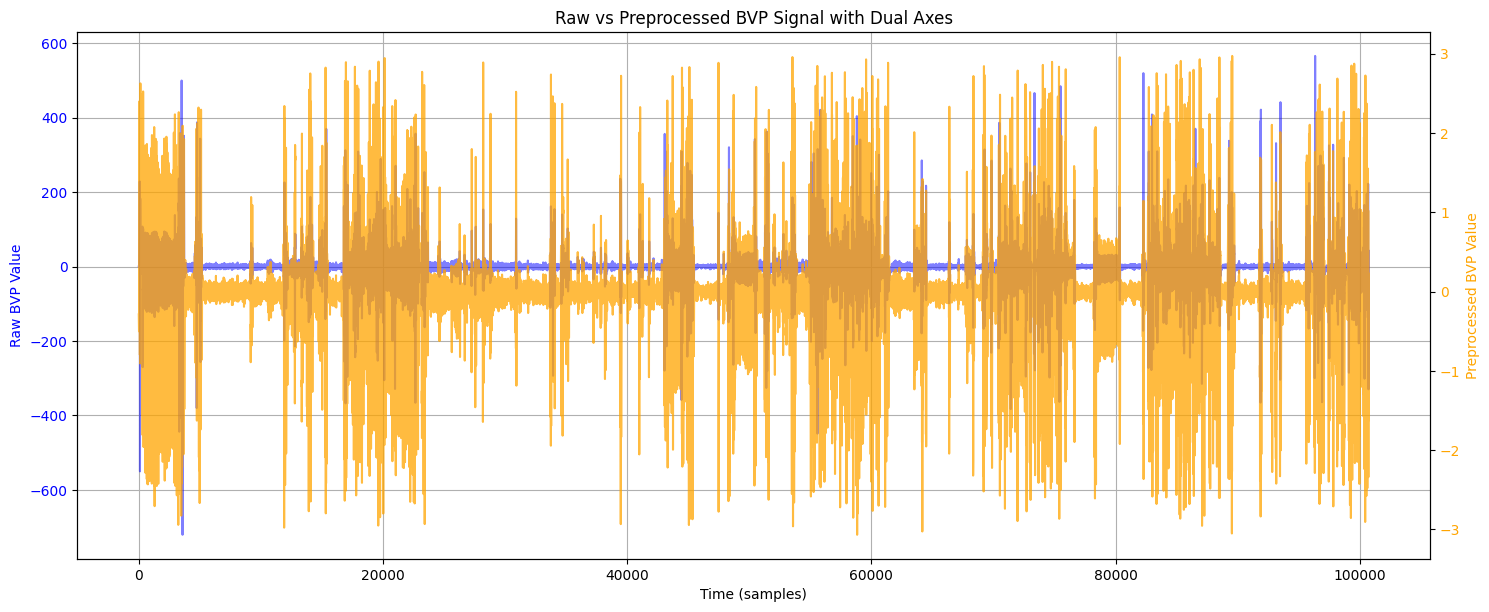

In [ ]:
# 3. Plotting with dual y-axes for comparison
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('Time (samples)')
ax1.set_ylabel('Raw BVP Value', color='blue')
ax1.plot(bvp_data['value'], label='Raw Signal', color='blue', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Preprocessed BVP Value', color='orange')
ax2.plot(bvp_data['smoothed_value'], label='Preprocessed Signal', color='orange', alpha=0.75)
ax2.tick_params(axis='y', labelcolor='orange')

fig.tight_layout()  # to make sure the labels and titles fit into the plot
plt.title('Raw vs Preprocessed BVP Signal with Dual Axes')
plt.show()

In [ ]:
# Static Analysis
def static_analysis(data):
    stats = {
        'mean': np.mean(data),
        'std_dev': np.std(data),
        'min': np.min(data),
        'max': np.max(data),
        'skewness': skew(data),
        'kurtosis': kurtosis(data)
    }
    return stats

In [ ]:
raw_stats = static_analysis(bvp_data['value'])
preprocessed_stats = static_analysis(bvp_data['smoothed_value'])

In [ ]:
# Print the static analysis results
print("Static Analysis of Raw BVP Signal:")
for key, value in raw_stats.items():
    print(f"{key}: {value}")

print("\nStatic Analysis of Preprocessed BVP Signal:")
for key, value in preprocessed_stats.items():
    print(f"{key}: {value}")

Static Analysis of Raw BVP Signal:
mean: -0.024838937034058973
std_dev: 54.08931976921687
min: -720.26
max: 565.31
skewness: 0.4584320686899181
kurtosis: 15.201829897654939

Static Analysis of Preprocessed BVP Signal:
mean: -0.006195182914007224
std_dev: 0.6677529937488402
min: -3.0668979603006243
max: 2.9712580204329373
skewness: -0.12277525521479647
kurtosis: 3.650501498357003


In [ ]:
# Define time-domain feature extraction functions
def extract_time_domain_features(segment):
    features = {}
    features['mean'] = np.mean(segment)
    features['std_dev'] = np.std(segment)
    features['energy'] = np.sum(segment ** 2)
    features['arc_length'] = np.sum(np.abs(np.diff(segment)))
    features['skewness'] = skew(segment)
    return features

In [ ]:
# Define frequency-domain feature extraction functions
def extract_frequency_domain_features(segment, fs):
    f, Pxx = welch(segment, fs=fs, nperseg=256)

    hf_band = (0.15, 0.4)
    lf_band = (0.04, 0.15)

    hf_indices = np.logical_and(f >= hf_band[0], f <= hf_band[1])
    lf_indices = np.logical_and(f >= lf_band[0], f <= lf_band[1])

    hf_psd = np.sum(Pxx[hf_indices])
    lf_psd = np.sum(Pxx[lf_indices])

    total_psd = np.sum(Pxx)

    rhfpsd = hf_psd / total_psd
    rlfpsd = lf_psd / total_psd

    features = {
        'hf_psd': hf_psd,
        'rhfpsd': rhfpsd,
        'lf_psd': lf_psd,
        'rlfpsd': rlfpsd
    }

    return features

In [ ]:
# Define additional feature extraction functions (STFT skewness, kurtosis)
def extract_additional_features(segment, fs):
    f, t, Zxx = stft(segment, fs=fs, nperseg=128)
    stft_magnitude = np.abs(Zxx)

    stft_skewness = skew(stft_magnitude.flatten())
    stft_kurtosis = np.mean((stft_magnitude.flatten() - np.mean(stft_magnitude.flatten()))**4) / np.var(stft_magnitude.flatten())**2

    features = {
        'stft_skewness': stft_skewness,
        'stft_kurtosis': stft_kurtosis
    }

    return features

In [ ]:
# Integrate all feature extraction functions
def extract_all_features(bvp_data, fs, window_size=5):
    n_samples = int(window_size * fs)
    n_windows = len(bvp_data) // n_samples

    all_features = []

    for i in range(n_windows):
        segment = bvp_data['smoothed_value'].iloc[i*n_samples:(i+1)*n_samples]
        time_features = extract_time_domain_features(segment)
        freq_features = extract_frequency_domain_features(segment, fs)
        additional_features = extract_additional_features(segment, fs)

        features = {**time_features, **freq_features, **additional_features}
        all_features.append(features)

    return pd.DataFrame(all_features)

In [ ]:
# Extract all features
all_features = extract_all_features(bvp_data, fs)

NameError: name 'extract_all_features' is not defined

In [ ]:
# Synchronize with self-annotation data
bvp_data['timestamp'] = pd.to_datetime(bvp_data['timestamp'], unit='ms')
start_time = pd.to_datetime(1548120820000, unit='ms')
intervals = pd.date_range(start=start_time, periods=len(all_features), freq='5S')
all_features['interval_start'] = intervals

In [ ]:
self_annotation_data['interval_start'] = start_time + pd.to_timedelta(self_annotation_data['seconds'], unit='s')
synchronized_data = pd.merge_asof(all_features, self_annotation_data, on='interval_start', direction='nearest')


In [ ]:
synchronized_data.head()

,mean,std_dev,energy,arc_length,skewness,hf_psd,rhfpsd,lf_psd,rlfpsd,stft_skewness,stft_kurtosis,interval_start,seconds,a-v,emotion,emotion1
0,0.159809,0.842272,235.187435,33.103095,1.180371,0.255911,0.087603,0.0,0.0,3.333925,13.854801,2019-01-22 01:33:40,5,valence,neutral,boredom
1,0.049745,1.099546,387.672544,56.816313,-0.137867,0.015167,0.003855,0.0,0.0,3.501660,16.535277,2019-01-22 01:33:45,5,valence,neutral,boredom
2,0.015569,1.167097,435.954746,59.498626,-0.550365,0.000456,0.000082,0.0,0.0,3.535728,16.777738,2019-01-22 01:33:50,10,valence,neutral,boredom
3,-0.008534,1.208252,467.182465,61.185591,-0.331377,0.007124,0.001163,0.0,0.0,3.374125,15.144643,2019-01-22 01:33:55,15,valence,neutral,no emotion
4,-0.040026,1.211014,469.809887,63.462118,-0.429217,0.000190,0.000032,0.0,0.0,3.570898,17.377823,2019-01-22 01:34:00,20,valence,neutral,no emotion


In [ ]:
# Save or display the synchronized data
synchronized_data.to_csv('synchronized_data.csv', index=False)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
# Define feature columns and target columns
feature_columns = [
    'arc_length', 'energy', 'hf_psd', 'lf_psd', 'mean',
    'rhfpsd', 'rlfpsd', 'skewness', 'std_dev', 'stft_kurtosis', 'stft_skewness'
]
target_columns = ['a-v', 'emotion', 'emotion1']

In [ ]:
# Separate features and targets
X = synchronized_data[feature_columns]
y = synchronized_data[target_columns]

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the base classifier
base_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Define the multi-output classifier
multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs=-1)

In [ ]:
# Train the classifier
multi_target_classifier.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42),
                      n_jobs=-1)

In [ ]:
# Predict on the test data
y_pred = multi_target_classifier.predict(X_test)

In [ ]:
# Evaluate the classifier
for i, target_name in enumerate(target_columns):
    print(f"Classification report for {target_name}:")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i]))
    print("\n")

Classification report for a-v:
              precision    recall  f1-score   support

     arousal       0.00      0.00      0.00         2
     valence       0.97      1.00      0.98        61

    accuracy                           0.97        63
   macro avg       0.48      0.50      0.49        63
weighted avg       0.94      0.97      0.95        63



Classification report for emotion:
              precision    recall  f1-score   support

       happy       0.00      0.00      0.00         3
     nervous       0.00      0.00      0.00         2
     neutral       0.92      1.00      0.96        58

    accuracy                           0.92        63
   macro avg       0.31      0.33      0.32        63
weighted avg       0.85      0.92      0.88        63



Classification report for emotion1:
               precision    recall  f1-score   support

concentration       0.70      0.64      0.67        36
      delight       0.00      0.00      0.00         2
   no emotion       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
!pip install pyentrp # Install the pyentrp module

import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, detrend, welch
from scipy.stats import skew, kurtosis, zscore
from pyentrp import entropy as ent
import matplotlib.pyplot as plt

In [ ]:
# Load the EDA data
eda_data = pd.read_csv('/content/sample_data/E4_EDA.csv')
eda_data['timestamp'] = pd.to_datetime(eda_data['timestamp'], unit='ms')
eda_values = eda_data['value'].values

In [ ]:
# Define filter functions
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

In [ ]:
def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
def highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filtering
fs = 4  # Sampling frequency (4 Hz for EDA data)
low_cutoff = 1.0  # Low-pass filter cutoff frequency (Hz)
high_cutoff = 0.01  # High-pass filter cutoff frequency (Hz)

In [ ]:
eda_filtered = lowpass_filter(eda_values, low_cutoff, fs)
eda_filtered = highpass_filter(eda_filtered, high_cutoff, fs)

In [ ]:
# Detrending
eda_detrended = detrend(eda_filtered)

In [ ]:
# Artifact Removal
# 1. Detect and remove large motion artifacts using a threshold (e.g., changes greater than 3 standard deviations)
eda_zscores = zscore(eda_detrended)
artifact_indices = np.where(np.abs(eda_zscores) > 3)[0]
eda_cleaned = np.delete(eda_detrended, artifact_indices)


In [ ]:
# 2. Interpolate to fill gaps left by artifact removal
eda_interpolated = np.interp(np.arange(len(eda_detrended)), np.setdiff1d(np.arange(len(eda_detrended)), artifact_indices), eda_cleaned)


In [ ]:
# Z-Score Normalization after artifact removal
eda_normalized = (eda_interpolated - np.mean(eda_interpolated)) / np.std(eda_interpolated)

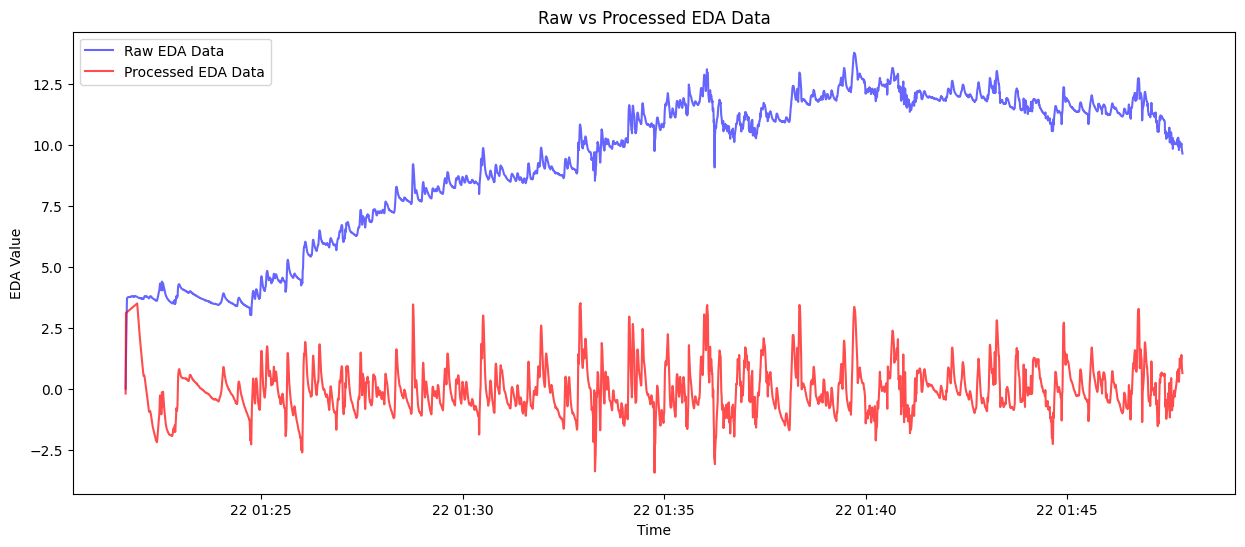

In [ ]:
# Plot Raw and Processed EDA Data
plt.figure(figsize=(15, 6))
plt.plot(eda_data['timestamp'], eda_values, label='Raw EDA Data', color='blue', alpha=0.6)
plt.plot(eda_data['timestamp'], eda_normalized, label='Processed EDA Data', color='red', alpha=0.7)
plt.title('Raw vs Processed EDA Data')
plt.xlabel('Time')
plt.ylabel('EDA Value')
plt.legend()
plt.show()

In [ ]:
# Perform Statistical Analysis on Processed Data
mean_eda = np.mean(eda_normalized)
std_eda = np.std(eda_normalized)
min_eda = np.min(eda_normalized)
max_eda = np.max(eda_normalized)
kurtosis_eda = kurtosis(eda_normalized)
skewness_eda = skew(eda_normalized)

In [ ]:
print("Statistical Analysis of Processed EDA Data:")
print(f"Mean: {mean_eda}")
print(f"Standard Deviation: {std_eda}")
print(f"Min Value: {min_eda}")
print(f"Max Value: {max_eda}")
print(f"Kurtosis: {kurtosis_eda}")
print(f"Skewness: {skewness_eda}")

Statistical Analysis of Processed EDA Data:
Mean: 4.51353175010386e-18
Standard Deviation: 1.0
Min Value: -3.449458956326034
Max Value: 3.5086231341524217
Kurtosis: 1.5226341121111027
Skewness: 0.8175561794604848


In [ ]:
# Trough-to-Peak Feature Extraction
def extract_trough_to_peak_features(eda_signal, fs):
    # Number of SCRs
    number_of_scrs = np.sum(eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal))
    summed_magnitude_of_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])
    summed_area_under_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])

    return {
        'Number_of_SCRs': number_of_scrs,
        'Summed_Magnitude_of_SCRs': summed_magnitude_of_scrs,
        'Summed_Area_Under_SCRs': summed_area_under_scrs
    }

In [ ]:
# Decomposition-Based Feature Extraction
def extract_decomposition_features(eda_signal):
    mean_tonic_level = np.mean(eda_signal)
    std_tonic_level = np.std(eda_signal)
    mean_phasic_activity = np.mean(np.diff(eda_signal))  # Using difference as a proxy for phasic
    number_of_responses = np.sum(np.diff(eda_signal) > 0)

    return {
        'Mean_Tonic_Level': mean_tonic_level,
        'Std_Tonic_Level': std_tonic_level,
        'Mean_Phasic_Activity': mean_phasic_activity,
        'Number_of_Responses': number_of_responses
    }

In [ ]:
# Additional Statistical Features
def extract_statistical_features(eda_signal):
    skewness = skew(eda_signal)
    kurtosis_value = kurtosis(eda_signal)

    return {
        'Skewness': skewness,
        'Kurtosis': kurtosis_value
    }

In [ ]:
# Segment the data into 5-second windows and extract features
window_size = 5 * fs  # 5 seconds worth of data

In [ ]:
features_list = []
for start in range(0, len(eda_normalized), window_size):
    end = start + window_size
    if end > len(eda_normalized):
        break
    window_eda = eda_normalized[start:end]
    features = {}
    features.update(extract_trough_to_peak_features(window_eda, fs))
    features.update(extract_decomposition_features(window_eda))
    features.update(extract_statistical_features(window_eda))
    features_list.append(features)

In [ ]:
# Convert to DataFrame
features_df = pd.DataFrame(features_list)

In [ ]:
# Load the synchronized data
sync_data = pd.read_csv('/content/sample_data/synchronized_data.csv')

In [ ]:
# Start time for EDA data in milliseconds
start_time = 1548120820000
start_time = pd.to_datetime(start_time, unit='ms')

In [ ]:
# Calculate the timestamp for each 5-second interval
features_df['timestamp'] = pd.date_range(start=start_time, periods=len(features_df), freq='5S')

In [ ]:
# Convert timestamp to seconds since the start time
features_df['seconds'] = (features_df['timestamp'] - start_time).dt.total_seconds()

In [ ]:
# Synchronize the data based on the 'seconds' column
synchronized_data = pd.merge(features_df, sync_data, on='seconds', how='inner')

In [ ]:
# Save the final synchronized data
synchronized_data.to_csv('synchronized_eda_features_final.csv', index=False)

In [ ]:
# Load the EDA data
eda_data = pd.read_csv('/content/sample_data/E4_EDA4.csv')
eda_data['timestamp'] = pd.to_datetime(eda_data['timestamp'], unit='ms')
eda_values = eda_data['value'].values

In [ ]:
# Define filter functions
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filtering
fs = 4  # Sampling frequency (4 Hz for EDA data)
low_cutoff = 1.0  # Low-pass filter cutoff frequency (Hz)
high_cutoff = 0.01  # High-pass filter cutoff frequency (Hz)

In [ ]:
eda_filtered = lowpass_filter(eda_values, low_cutoff, fs)
eda_filtered = highpass_filter(eda_filtered, high_cutoff, fs)

In [ ]:
# Detrending
eda_detrended = detrend(eda_filtered)

In [ ]:
# Artifact Removal
eda_zscores = np.abs((eda_detrended - np.mean(eda_detrended)) / np.std(eda_detrended))
artifact_indices = np.where(eda_zscores > 3)[0]
eda_cleaned = np.delete(eda_detrended, artifact_indices)

In [ ]:
# Interpolate to fill gaps left by artifact removal
eda_interpolated = np.interp(np.arange(len(eda_detrended)), np.setdiff1d(np.arange(len(eda_detrended)), artifact_indices), eda_cleaned)

In [ ]:
# Z-Score Normalization after artifact removal
eda_normalized = (eda_interpolated - np.mean(eda_interpolated)) / np.std(eda_interpolated)

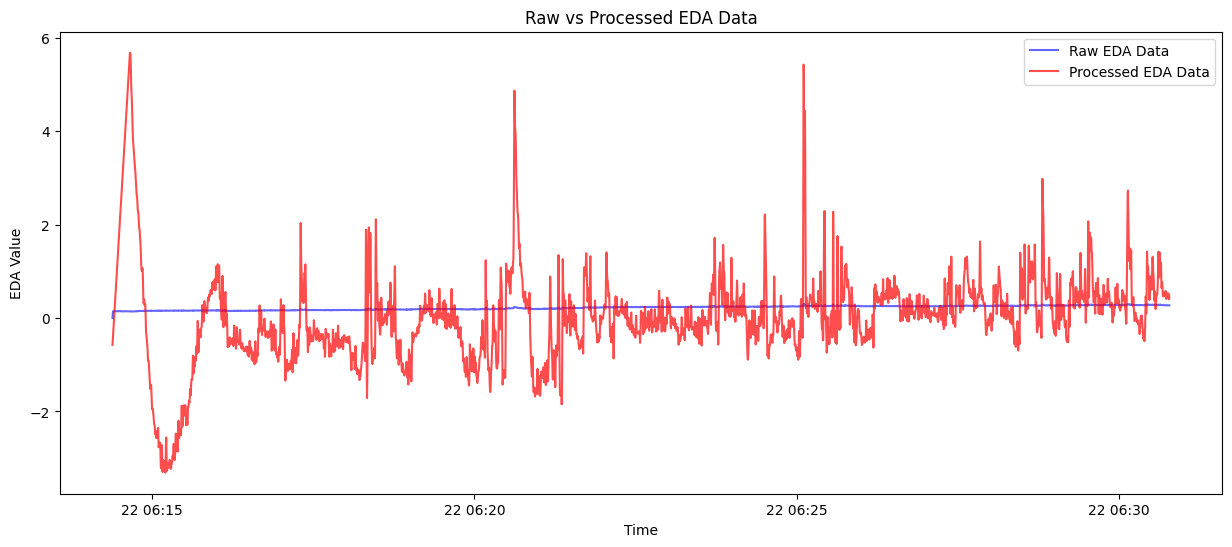

In [ ]:
# Plot Raw and Processed EDA Data
plt.figure(figsize=(15, 6))
plt.plot(eda_data['timestamp'], eda_values, label='Raw EDA Data', color='blue', alpha=0.6)
plt.plot(eda_data['timestamp'], eda_normalized, label='Processed EDA Data', color='red', alpha=0.7)
plt.title('Raw vs Processed EDA Data')
plt.xlabel('Time')
plt.ylabel('EDA Value')
plt.legend()
plt.show()

In [ ]:
# Trough-to-Peak Feature Extraction
def extract_trough_to_peak_features(eda_signal, fs):
    # Number of SCRs
    number_of_scrs = np.sum(eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal))
    summed_magnitude_of_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])
    summed_area_under_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])

    return {
        'Number_of_SCRs': number_of_scrs,
        'Summed_Magnitude_of_SCRs': summed_magnitude_of_scrs,
        'Summed_Area_Under_SCRs': summed_area_under_scrs
    }

In [ ]:
# Decomposition-Based Feature Extraction
def extract_decomposition_features(eda_signal):
    mean_tonic_level = np.mean(eda_signal)
    std_tonic_level = np.std(eda_signal)
    mean_phasic_activity = np.mean(np.diff(eda_signal))  # Using difference as a proxy for phasic
    number_of_responses = np.sum(np.diff(eda_signal) > 0)

    return {
        'Mean_Tonic_Level': mean_tonic_level,
        'Std_Tonic_Level': std_tonic_level,
        'Mean_Phasic_Activity': mean_phasic_activity,
        'Number_of_Responses': number_of_responses
    }

In [ ]:
# Additional Statistical Features
def extract_statistical_features(eda_signal):
    skewness = skew(eda_signal)
    kurtosis_value = kurtosis(eda_signal)

    return {
        'Skewness': skewness,
        'Kurtosis': kurtosis_value
    }

In [ ]:
# Segment the data into 5-second windows and extract features
window_size = 5 * fs  # 5 seconds worth of data

In [ ]:
features_list = []
for start in range(0, len(eda_normalized), window_size):
    end = start + window_size
    if end > len(eda_normalized):
        break
    window_eda = eda_normalized[start:end]
    features = {}
    features.update(extract_trough_to_peak_features(window_eda, fs))
    features.update(extract_decomposition_features(window_eda))
    features.update(extract_statistical_features(window_eda))
    features_list.append(features)

In [ ]:
# Convert to DataFrame
features_df = pd.DataFrame(features_list)

In [ ]:
# Load the synchronized data
sync_data = pd.read_csv('/content/sample_data/synchronized4_data.csv')

In [ ]:
# Start time for EDA data in milliseconds
start_time = 1548137961000
start_time = pd.to_datetime(start_time, unit='ms')

In [ ]:
# Calculate the timestamp for each 5-second interval
features_df['timestamp'] = pd.date_range(start=start_time, periods=len(features_df), freq='5S')



In [ ]:
# Convert timestamp to seconds since the start time
features_df['seconds'] = (features_df['timestamp'] - start_time).dt.total_seconds()

In [ ]:
# Synchronize the data based on the 'seconds' column
synchronized_data = pd.merge(features_df, sync_data, on='seconds', how='inner')

In [ ]:
# Save the final synchronized data
synchronized_data.to_csv('synchronized4_eda_features_final.csv', index=False)

In [ ]:
# Load the EDA data
eda_data = pd.read_csv('/content/sample_data/E4_EDA5.csv')
eda_data['timestamp'] = pd.to_datetime(eda_data['timestamp'], unit='ms')
eda_values = eda_data['value'].values

In [ ]:
# Define filter functions
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filtering
fs = 4  # Sampling frequency (4 Hz for EDA data)
low_cutoff = 1.0  # Low-pass filter cutoff frequency (Hz)
high_cutoff = 0.01  # High-pass filter cutoff frequency (Hz)

In [ ]:
eda_filtered = lowpass_filter(eda_values, low_cutoff, fs)
eda_filtered = highpass_filter(eda_filtered, high_cutoff, fs)

In [ ]:
# Detrending
eda_detrended = detrend(eda_filtered)

In [ ]:
# Artifact Removal
eda_zscores = np.abs((eda_detrended - np.mean(eda_detrended)) / np.std(eda_detrended))
artifact_indices = np.where(eda_zscores > 3)[0]
eda_cleaned = np.delete(eda_detrended, artifact_indices)

In [ ]:
# Interpolate to fill gaps left by artifact removal
eda_interpolated = np.interp(np.arange(len(eda_detrended)), np.setdiff1d(np.arange(len(eda_detrended)), artifact_indices), eda_cleaned)

In [ ]:
# Z-Score Normalization after artifact removal
eda_normalized = (eda_interpolated - np.mean(eda_interpolated)) / np.std(eda_interpolated)

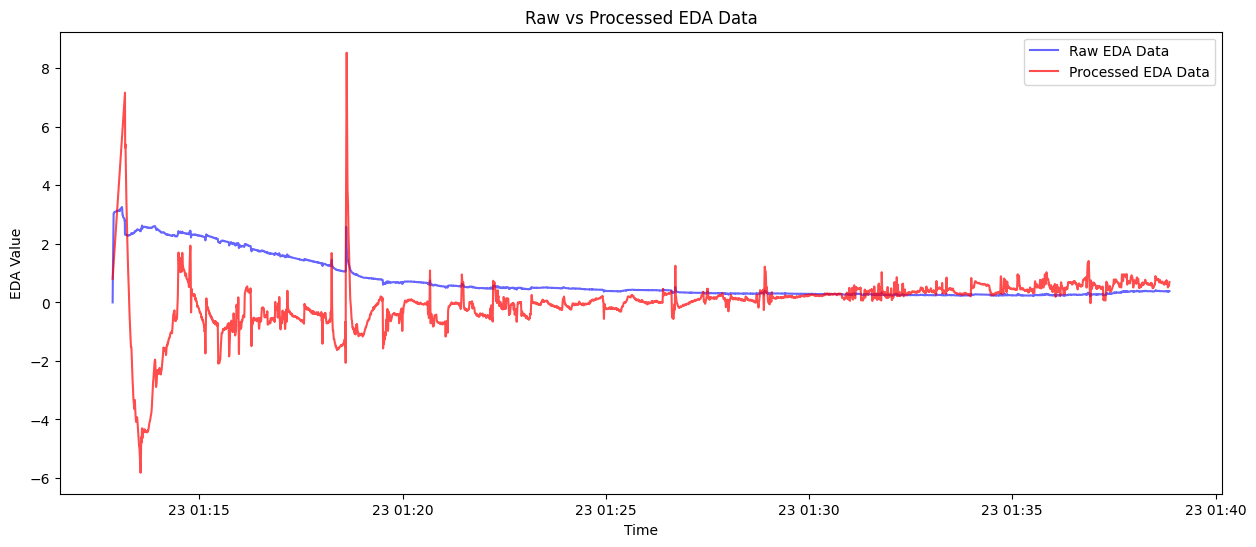

In [ ]:
# Plot Raw and Processed EDA Data
plt.figure(figsize=(15, 6))
plt.plot(eda_data['timestamp'], eda_values, label='Raw EDA Data', color='blue', alpha=0.6)
plt.plot(eda_data['timestamp'], eda_normalized, label='Processed EDA Data', color='red', alpha=0.7)
plt.title('Raw vs Processed EDA Data')
plt.xlabel('Time')
plt.ylabel('EDA Value')
plt.legend()
plt.show()

In [ ]:
# Trough-to-Peak Feature Extraction
def extract_trough_to_peak_features(eda_signal, fs):
    # Number of SCRs
    number_of_scrs = np.sum(eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal))
    summed_magnitude_of_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])
    summed_area_under_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])

    return {
        'Number_of_SCRs': number_of_scrs,
        'Summed_Magnitude_of_SCRs': summed_magnitude_of_scrs,
        'Summed_Area_Under_SCRs': summed_area_under_scrs
    }

In [ ]:
# Decomposition-Based Feature Extraction
def extract_decomposition_features(eda_signal):
    mean_tonic_level = np.mean(eda_signal)
    std_tonic_level = np.std(eda_signal)
    mean_phasic_activity = np.mean(np.diff(eda_signal))  # Using difference as a proxy for phasic
    number_of_responses = np.sum(np.diff(eda_signal) > 0)

    return {
        'Mean_Tonic_Level': mean_tonic_level,
        'Std_Tonic_Level': std_tonic_level,
        'Mean_Phasic_Activity': mean_phasic_activity,
        'Number_of_Responses': number_of_responses
    }

In [ ]:
# Additional Statistical Features
def extract_statistical_features(eda_signal):
    skewness = skew(eda_signal)
    kurtosis_value = kurtosis(eda_signal)

    return {
        'Skewness': skewness,
        'Kurtosis': kurtosis_value
    }

In [ ]:
# Segment the data into 5-second windows and extract features
window_size = 5 * fs  # 5 seconds worth of data

In [ ]:
features_list = []
for start in range(0, len(eda_normalized), window_size):
    end = start + window_size
    if end > len(eda_normalized):
        break
    window_eda = eda_normalized[start:end]
    features = {}
    features.update(extract_trough_to_peak_features(window_eda, fs))
    features.update(extract_decomposition_features(window_eda))
    features.update(extract_statistical_features(window_eda))
    features_list.append(features)

In [ ]:
# Convert to DataFrame
features_df = pd.DataFrame(features_list)


In [ ]:
# Load the synchronized data
sync_data = pd.read_csv('/content/sample_data/synchronized5_data.csv')

In [ ]:
# Start time for EDA data in milliseconds
start_time = 1548206905000
start_time = pd.to_datetime(start_time, unit='ms')

In [ ]:
# Calculate the timestamp for each 5-second interval
features_df['timestamp'] = pd.date_range(start=start_time, periods=len(features_df), freq='5S')


In [ ]:
# Convert timestamp to seconds since the start time
features_df['seconds'] = (features_df['timestamp'] - start_time).dt.total_seconds()

In [ ]:
# Synchronize the data based on the 'seconds' column
synchronized_data = pd.merge(features_df, sync_data, on='seconds', how='inner')

In [ ]:
# Save the final synchronized data
synchronized_data.to_csv('synchronized5_eda_features_final.csv', index=False)

In [ ]:
# Load the EDA data
eda_data = pd.read_csv('/content/sample_data/E4_EDA31.csv')
eda_data['timestamp'] = pd.to_datetime(eda_data['timestamp'], unit='ms')
eda_values = eda_data['value'].values

In [ ]:
# Define filter functions
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filtering
fs = 4  # Sampling frequency (4 Hz for EDA data)
low_cutoff = 1.0  # Low-pass filter cutoff frequency (Hz)
high_cutoff = 0.01  # High-pass filter cutoff frequency (Hz)

In [ ]:
eda_filtered = lowpass_filter(eda_values, low_cutoff, fs)
eda_filtered = highpass_filter(eda_filtered, high_cutoff, fs)

In [ ]:
# Detrending
eda_detrended = detrend(eda_filtered)

In [ ]:
# Detect and correct artifacts (sharp spikes)
def detect_and_correct_artifacts(eda_signal, threshold=3.0):
    # Calculate the Z-scores of the signal
    z_scores = zscore(eda_signal)

    # Identify where the Z-scores exceed the threshold (potential spikes)
    artifact_indices = np.where(np.abs(z_scores) > threshold)[0]

    # Correct artifacts by interpolating the values
    corrected_signal = eda_signal.copy()
    for index in artifact_indices:
        # Replace the artifact with the mean of neighboring points
        if 0 < index < len(eda_signal) - 1:
            corrected_signal[index] = (eda_signal[index - 1] + eda_signal[index + 1]) / 2

    return corrected_signal

In [ ]:
eda_corrected = detect_and_correct_artifacts(eda_detrended)

In [ ]:
# Z-Score Normalization
eda_normalized = (eda_corrected - np.mean(eda_corrected)) / np.std(eda_corrected)

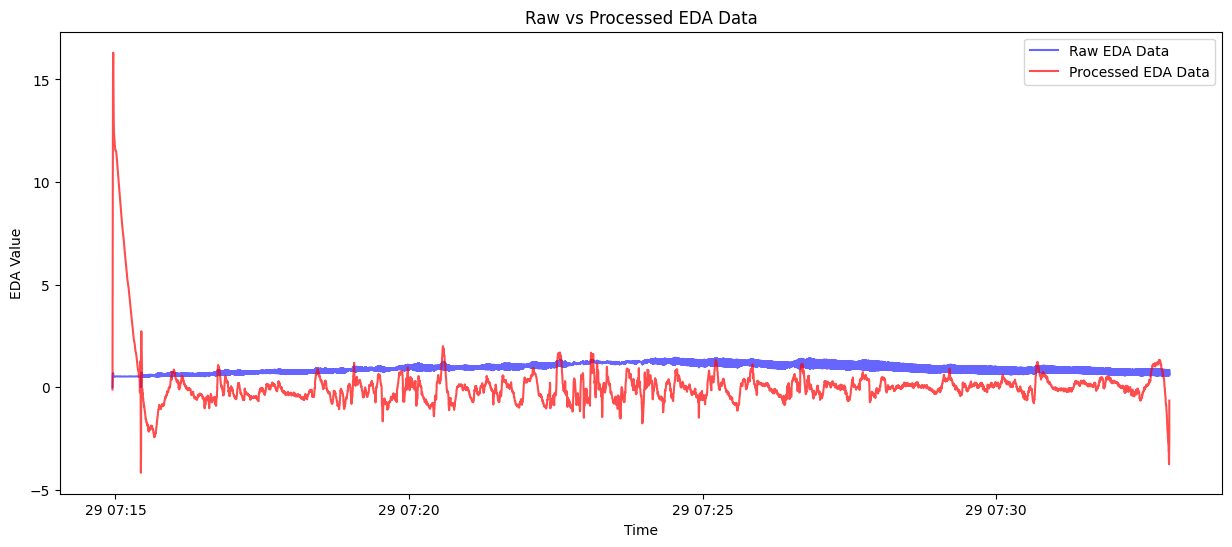

In [ ]:
# Plot Raw and Processed EDA Data
plt.figure(figsize=(15, 6))
plt.plot(eda_data['timestamp'], eda_values, label='Raw EDA Data', color='blue', alpha=0.6)
plt.plot(eda_data['timestamp'], eda_normalized, label='Processed EDA Data', color='red', alpha=0.7)
plt.title('Raw vs Processed EDA Data')
plt.xlabel('Time')
plt.ylabel('EDA Value')
plt.legend()
plt.show()

In [ ]:
# Trough-to-Peak Feature Extraction
def extract_trough_to_peak_features(eda_signal, fs):
    # Number of SCRs
    number_of_scrs = np.sum(eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal))
    summed_magnitude_of_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])
    summed_area_under_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])

    return {
        'Number_of_SCRs': number_of_scrs,
        'Summed_Magnitude_of_SCRs': summed_magnitude_of_scrs,
        'Summed_Area_Under_SCRs': summed_area_under_scrs
    }

In [ ]:
# Decomposition-Based Feature Extraction
def extract_decomposition_features(eda_signal):
    mean_tonic_level = np.mean(eda_signal)
    std_tonic_level = np.std(eda_signal)
    mean_phasic_activity = np.mean(np.diff(eda_signal))  # Using difference as a proxy for phasic
    number_of_responses = np.sum(np.diff(eda_signal) > 0)

    return {
        'Mean_Tonic_Level': mean_tonic_level,
        'Std_Tonic_Level': std_tonic_level,
        'Mean_Phasic_Activity': mean_phasic_activity,
        'Number_of_Responses': number_of_responses
    }

In [ ]:
# Additional Statistical Features
def extract_statistical_features(eda_signal):
    skewness = skew(eda_signal)
    kurtosis_value = kurtosis(eda_signal)

    return {
        'Skewness': skewness,
        'Kurtosis': kurtosis_value
    }

In [ ]:
# Segment the data into 5-second windows and extract features
window_size = 5 * fs  # 5 seconds worth of data

In [ ]:
features_list = []
for start in range(0, len(eda_normalized), window_size):
    end = start + window_size
    if end > len(eda_normalized):
        break
    window_eda = eda_normalized[start:end]
    features = {}
    features.update(extract_trough_to_peak_features(window_eda, fs))
    features.update(extract_decomposition_features(window_eda))
    features.update(extract_statistical_features(window_eda))
    features_list.append(features)

In [ ]:
# Convert to DataFrame
features_df = pd.DataFrame(features_list)

In [ ]:
# Load the synchronized data
sync_data = pd.read_csv('/content/sample_data/synchronized31_data.csv')

In [ ]:
# Start time for EDA data in milliseconds
start_time = 1553844121000
start_time = pd.to_datetime(start_time, unit='ms')

In [ ]:
# Calculate the timestamp for each 5-second interval
features_df['timestamp'] = pd.date_range(start=start_time, periods=len(features_df), freq='5S')

In [ ]:
# Convert timestamp to seconds since the start time
features_df['seconds'] = (features_df['timestamp'] - start_time).dt.total_seconds()

In [ ]:
# Synchronize the data based on the 'seconds' column
synchronized_data = pd.merge(features_df, sync_data, on='seconds', how='inner')

In [ ]:
# Save the final synchronized data
synchronized_data.to_csv('synchronized31_eda_features_final.csv', index=False)

# Heart Feature Extraction

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pywt

In [ ]:
# Load the HR data
hr_data = pd.read_csv('/content/sample_data/Polar_HR31.csv')

In [ ]:
def butter_lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Parameters for low-pass filter
cutoff = 0.4  # Cutoff frequency (Hz) for low-pass filtering
fs = 1.0  # Sampling frequency in Hz

In [ ]:
# Apply the low-pass filter to the heart rate data
hr_data['value_filtered'] = butter_lowpass_filter(hr_data['value'], cutoff, fs)

In [ ]:

def wavelet_denoise(data, wavelet='db4', level=1):
    coeffs = pywt.wavedec(data, wavelet, mode='symmetric')
    sigma = (1/0.6745) * np.median(np.abs(coeffs[-level] - np.median(coeffs[-level])))
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs = [pywt.threshold(i, value=uthresh, mode='hard') for i in coeffs]
    denoised_data = pywt.waverec(coeffs, wavelet, mode='symmetric')

    # Ensure the denoised data matches the original length
    if len(denoised_data) > len(data):
        denoised_data = denoised_data[:len(data)]
    elif len(denoised_data) < len(data):
        denoised_data = np.pad(denoised_data, (0, len(data) - len(denoised_data)), 'edge')

    return denoised_data

In [ ]:
# Apply wavelet denoising to the filtered heart rate data
hr_data['value_denoised'] = wavelet_denoise(hr_data['value_filtered'])

In [ ]:
# Convert timestamp to seconds relative to the start time
start_time = 1553844121000
hr_data['seconds'] = (hr_data['timestamp'] - start_time) / 1000.0

In [ ]:
# Filter to only include data from the start time
hr_data_filtered = hr_data[hr_data['seconds'] >= 0].copy()

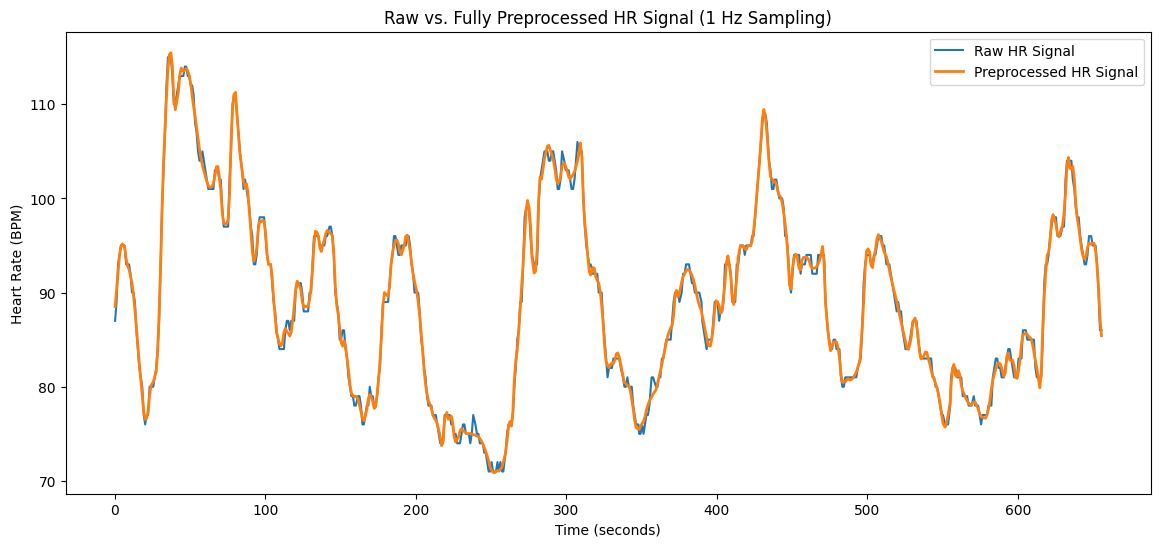

In [ ]:
# Plot the raw vs. preprocessed heart rate data
plt.figure(figsize=(14, 6))
plt.plot(hr_data_filtered['seconds'], hr_data_filtered['value'], label='Raw HR Signal')
plt.plot(hr_data_filtered['seconds'], hr_data_filtered['value_denoised'], label='Preprocessed HR Signal', linewidth=2)
plt.xlabel('Time (seconds)')
plt.ylabel('Heart Rate (BPM)')
plt.title('Raw vs. Fully Preprocessed HR Signal (1 Hz Sampling)')
plt.legend()
plt.show()

In [ ]:
# 1. Basic Descriptive Statistics
raw_mean = np.mean(hr_data['value'])
preprocessed_mean = np.mean(hr_data['value_denoised'])

raw_std = np.std(hr_data['value'])
preprocessed_std = np.std(hr_data['value_denoised'])

raw_range = np.ptp(hr_data['value'])  # Peak to peak (range)
preprocessed_range = np.ptp(hr_data['value_denoised'])

print("Descriptive Statistics:")
print(f"Raw Signal - Mean: {raw_mean}, Std Dev: {raw_std}, Range: {raw_range}")
print(f"Preprocessed Signal - Mean: {preprocessed_mean}, Std Dev: {preprocessed_std}, Range: {preprocessed_range}")

Descriptive Statistics:
Raw Signal - Mean: 89.5250255362615, Std Dev: 11.311367043221505, Range: 53.0
Preprocessed Signal - Mean: 89.52603447169668, Std Dev: 11.289793147140514, Range: 52.56386795366342


In [ ]:
def calculate_hrv_features(hr_values):
    rr_intervals = 60000 / hr_values
    diff_rr = np.diff(rr_intervals)

    avnn = np.mean(rr_intervals)
    cv = np.std(rr_intervals) / avnn if avnn != 0 else 0
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(diff_rr ** 2))
    sdsd = np.std(diff_rr)
    nn50 = np.sum(np.abs(diff_rr) > 50)
    pnn50 = nn50 / len(diff_rr) if len(diff_rr) > 0 else 0

    return pd.Series({
        'AVNN': avnn,
        'CV': cv,
        'SDNN': sdnn,
        'RMSSD': rmssd,
        'SDSD': sdsd,
        'NN50': nn50,
        'pNN50': pnn50
    })

In [ ]:
# Define window size (30 seconds) and step size (5 seconds)
window_size = 30  # Assuming 1 Hz data, this would be 30 seconds
step_size = 5  # Slide the window by 5 seconds

In [ ]:
# Extract HRV features using a rolling window
hrv_feature_list = []

In [ ]:
for start in range(0, len(hr_data_filtered) - window_size, step_size):
    end = start + window_size
    hr_values_window = hr_data_filtered['value_denoised'].iloc[start:end]

    # Calculate HRV features for this window
    hrv_features = calculate_hrv_features(hr_values_window)
    hrv_feature_list.append(hrv_features)

In [ ]:
# Convert the list of features to a DataFrame
hrv_feature_df = pd.DataFrame(hrv_feature_list)

In [ ]:
# Align the HRV features with the corresponding time in the HR data
hrv_feature_df['seconds'] = hr_data_filtered['seconds'].iloc[::step_size].values[:len(hrv_feature_df)]
hrv_feature_df['seconds'] = hrv_feature_df['seconds'].astype(int)  # Convert seconds to integer for merging

In [ ]:
# Load the P1.self data
p1_self_data = pd.read_csv('/content/sample_data/synchronized31_eda_features_final.csv')

In [ ]:
# Convert the 'seconds' column in both DataFrames to integer to ensure compatibility
hrv_feature_df['seconds'] = hrv_feature_df['seconds'].astype(int)
p1_self_data['seconds'] = p1_self_data['seconds'].astype(int)

In [ ]:
# Now perform the merge
merged_data = pd.merge_asof(p1_self_data, hrv_feature_df, on='seconds')

In [ ]:

# Drop NN50 and pNN50 if they are not useful
merged_data = merged_data.drop(columns=['NN50', 'pNN50'], errors='ignore')

In [ ]:
# Save or return the merged data for further analysis or model training
merged_data.to_csv('synchronized31_hrv_data.csv', index=False)

# **BVP** **FEATURE** **EXTRACTION**

In [ ]:
pip install antropy


In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, detrend, savgol_filter, welch
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
import antropy as ent
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Load the data
bvp_data = pd.read_csv('/content/sample_data/E4_BVP31.csv')
sync_data = pd.read_csv('/content/sample_data/synchronized31_hrv_data.csv')

In [ ]:
# Define a butterworth filter function
def butter_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [ ]:
# Sampling frequency
fs = 64  # Assuming BVP data was sampled at 64 Hz

In [ ]:
# Apply bandpass filter (0.5 Hz to 5 Hz)
bvp_data['filtered'] = butter_filter(bvp_data['value'], lowcut=0.5, highcut=5, fs=fs, order=5)


In [ ]:
# Artifact Removal - Simple Thresholding
artifact_threshold = bvp_data['filtered'].mean() + 3 * bvp_data['filtered'].std()
bvp_data['artifact_removed'] = bvp_data['filtered']
bvp_data.loc[bvp_data['artifact_removed'] > artifact_threshold, 'artifact_removed'] = np.nan
bvp_data['artifact_removed'] = bvp_data['artifact_removed'].interpolate()

In [ ]:
# Apply Savitzky-Golay filter for smoothing
bvp_data['smoothed'] = savgol_filter(bvp_data['artifact_removed'], window_length=51, polyorder=3)

In [ ]:
# Z-Score Normalization
scaler = StandardScaler()
bvp_data['normalized'] = scaler.fit_transform(bvp_data[['smoothed']])

In [ ]:
# Check for any NaN or empty values after preprocessing
print("After preprocessing, check for NaN or empty values:")
print(bvp_data.isnull().sum())

After preprocessing, check for NaN or empty values:
timestamp           0
pid                 0
value               0
device_serial       0
device_number       0
entry_time          0
filtered            0
artifact_removed    0
smoothed            0
normalized          0
dtype: int64


In [ ]:
def extract_features(data, window_size, fs):
    features = []
    for i in range(0, len(data) - window_size, window_size):
        window = data[i:i + window_size]

        # Check if the window is empty or contains NaN values
        if len(window) == 0 or np.isnan(window).any():
            print(f"Skipping empty or NaN-containing window at index {i}")
            continue

        mean_val = np.mean(window)
        std_val = np.std(window)
        arc_length = np.sum(np.abs(np.diff(window)))
        skewness = skew(window)
        kurt = kurtosis(window)

        # Frequency-Domain Features
        f, Pxx = welch(window, fs=fs, nperseg=window_size)
        hf_psd = np.sum(Pxx[(f >= 0.15) & (f <= 0.4)])  # High frequency band (0.15-0.4 Hz)
        lf_psd = np.sum(Pxx[(f >= 0.04) & (f <= 0.15)])  # Low frequency band (0.04-0.15 Hz)
        rhf_psd = hf_psd / lf_psd if lf_psd != 0 else 0  # Handle division by zero

        # Entropy Features (using antropy)
        sampen = ent.sample_entropy(window, order=2)

        features.append([mean_val, std_val, arc_length, skewness, kurt, hf_psd, rhf_psd, sampen])

    # Convert the list of features into a DataFrame
    features_df = pd.DataFrame(features, columns=['Mean', 'Std_Dev', 'Arc_Length', 'Skewness', 'Kurtosis', 'HF_PSD', 'RHF_PSD', 'SampEn'])

    # Check if the feature DataFrame is empty
    print("Feature DataFrame head:")
    print(features_df.head())

    return features_df

In [ ]:
# Extract features with a window size corresponding to 5-second intervals
window_size = fs * 5
features_df = extract_features(bvp_data['normalized'].values, window_size, fs)


Feature DataFrame head:
       Mean   Std_Dev  Arc_Length  Skewness  Kurtosis     HF_PSD  RHF_PSD  \
0 -0.701099  4.385620   76.378503 -1.946464  3.991468  11.298130        0   
1 -0.304391  2.297189   50.616803 -0.954610  1.315840   0.976122        0   
2 -0.029581  1.254842   41.327307  0.143541 -1.067469   0.006409        0   
3  0.019044  1.076940   35.508366  0.086697 -1.367555   0.001958        0   
4  0.024922  0.903448   30.005975  0.077634 -1.421148   0.000448        0   

     SampEn  
0  0.162388  
1  0.292563  
2  0.372270  
3  0.334247  
4  0.311380  


In [ ]:
# Verify the feature extraction output
if features_df.empty:
    print("Warning: The features DataFrame is empty. No features were extracted.")

In [ ]:
# Define the start time for your BVP data in milliseconds
start_time = 1553844121000
start_time = pd.to_datetime(start_time, unit='ms')

In [ ]:
# Calculate the timestamp for each 5-second interval
features_df['timestamp'] = pd.date_range(start=start_time, periods=len(features_df), freq='5S')

In [ ]:
# Convert timestamp to seconds since the start time
features_df['seconds'] = (features_df['timestamp'] - start_time).dt.total_seconds()

In [ ]:
# Synchronize the features with the synchronized HRV data based on the 'seconds' column
synchronized_data = pd.merge(features_df, sync_data, on='seconds', how='inner')

In [ ]:
# Save the final synchronized data to a CSV file
synchronized_data.to_csv('synchronized31_bvp_features_final.csv', index=False)